# Project Overview

__Business Problem__

This project uses regression analysis to solve the problem of disposable buildings, or usage of buildings for a short life cycle. Building longevity, defined as the years of service of a building, has gone down over history resulting in the shortest building lifespans ever before in history. This creates an excess of physical waste being sent to landfills, and also reduces the potential return on investment for building owners. Most buildings generate revenue, so the longer they are in service, the greater return for the owner.

__Customers__

The potential users who would benefit from this analysis include long-term building owners such as real estate corporations and government agencies. Companies such as JLL, CBRE, and the Related Company own portfolios of hundreds or thousands of buildings. Government agencies such as HUD, the US Army Corps of Engineers, and Navy Facilities Command also own and maintain large portfolios. These customers are constantly evaluating whether to build new, renovate existing properties, or some combination of the th two.  Predicting building life span would benefit these customers by giving them a baseline understanding of what is the typical lifespan of a building within the set of buildings that are demolished.


__Analysis__

This analysis studies only demolished buildings. Future study could include study of existing buildings as well. Since some buildings are never demolished, or last far longer than typical buildings, these have different properties that can't be understood from studying only demolished buildings. However, a study of demolished buildings can reveal what factors may have influenced demolition and how this may be avoided for owners wishing to use their buildings for a longer lifespan.

__Target Variable__

The target is lifespan, defined as the total time the building was in service from date of construction to date of demolition, in years.

__Data__

Data was obtained from two sources: PLUTO, or Primary Land Use Tax Output, and NYC Open Data  Department of Buildings (DOB) Permit Issuance.

Pluto is a a system for keeping track of New York City land use data by lot. PLUTO compiles data from multiple sources including the NYC Department of City Planning, Department of Finance, Landmarks Preservation Commission, and the Department of Information, Telecommunications and Technology.

The permits data is being used to filter out the PLUTO data. The only columns from the permits data that are needed for this purpose are the columns used to merge (borough, block, and lot) as well as 'Bldg Type' (used to filter to commercial buildings), 'Residential' to check filtering, 'Permit Type' and 'Issuance Date' which describes when the demolition began. All other columns from the permits dataset are dropped.

__Data Cleaning__

The following columns are dropped for too many missing values:
- masdate
- polidate

The following columns are dropped beause they are not relevant:
- zmcode, a code which identifies a tax lot on the border of two zoning maps.  
- condono, the condominium number.
- owner name
- ct2010, the 2010 census tract in which the tax lot is located.
- tract2010, The 2010 census tract in which the tax lot is located. 
- cb2010, the 2010 census block in which the tax lot is located.
- firecomp, the fire company that services the tax lot.
- sanborn, the Sanborn Map Company map number associated with the tax block and lot.
- sanitsub, the subsection of the sanitation district that services the tax lot.
- address
- areasource, a code indicating the methodology used to determine the tax lot's TOTAL BUILDING FLOOR AREA (BldgArea) 
- zonemap, Department of City Planning Georeferenced NYC Zoning Maps 
- taxmap, the Department of Finance paper tax map volume number associated with the tax block and lot.
- appbbl, the originating BBL (borough, block and lot) from the apportionment prior to the merge, split or property’s conversion to a condominium.   
- appdate, the date of the apportionment to merge or split the property or convert to a condominium. 
- plutomapid, a code indicating whether the tax lot is in the PLUTO file, the MapPLUTO file with water areas included, and/or the MapPLUTO file that is clipped to the shoreline.
- rpaddate, not sure what this date represents, all values have the same date (not listed in the data dictionary.)
- dcasdate, not sure what this date represents, all values have the same date (not listed in the data dictionary.)
- edesigdate, not sure what this date represents, all values have the same date (not listed in the data dictionary.)
- geom, a code of numbers and letters that is illegible.
- zipcode, no need to sort by zip for the goal of the project.

The following columns are dropped because they are redundant with another column:
- sanitboro, redundant with borough
- Borough, redundant with borocode
- version, the version number for this release of PLUTO.

The following rows with missing values are dropped:
- yearbuilt
- Some tax lots have more than one building. Rows for lots with more than one building will be dropped.


The PLUTO data will be filtered using BBL number. \
BBL stands for borough, block and lot. \
example bbl number 1011270029:\
borough 1 for Manhattan\
block 01127\
lot 0029


__Final Features Used for Modeling:__

Feature descriptions come from the PLUTO data dictionary.

- irrlotcode - A code indicating whether the tax lot is irregularly shaped. 

&emsp; Y Yes, an irregularly shaped lot \
&emsp; N No, not an irregularly shaped lot

- bldgfront - The building’s frontage along the street measured in feet.

- ext - A code identifying whether there is an extension on the lot or a garage other than the primary structure.  

&emsp; E Extension \
&emsp; G Garage \
&emsp; EG Extension and garage \
&emsp; N None

- irrlotcode - A code indicating whether the tax lot is irregularly shaped. 

- splitzone - A code indicating whether the tax lot is split between multiple zoning features. The split boundary indicator is equal to “Y” if the tax lot has a value for ZONING DISTRICT 2, COMMERCIAL OVERLAY 2, or SPECIAL DISTRICT BOUNDARY 2.  

- bldgclass - A code describing the major use of structures on the tax lot. BUILDING CLASS is taken from Property Tax System (PTS) without modification. 

&emsp; 01 One & Two Family Buildings \
&emsp; 02 Multi-Family Walk-Up Buildings \
&emsp; 03 Multi-Family Elevator Buildings \
&emsp; 04 Mixed Residential & Commercial Buildings\
&emsp; 05 Commercial & Office Buildings\
&emsp; 06 Industrial & Manufacturing\
&emsp; 07 Transportation & Utility \
&emsp; 08 Public Facilities & Institutions \
&emsp; 09 Open Space & Outdoor Recreation \
&emsp; 10 Parking Facilities \
&emsp; 11 Vacant Land 

- ownertype - A code indicating type of ownership for the tax lot. 

&emsp; C City ownership \
&emsp; M Mixed city & private ownership \
&emsp; O Other – owned by either a public authority or the state or federal government \
&emsp; P Private ownership \
&emsp; X Fully tax-exempt property that may be owned by the city, state, or federal government; a public authority; or a private institution Unknown (usually private ownership) 

- yearbuilt - The date of original construction.

- histdist - The name of the Historic District that the tax lot is within. Historic Districts are designated by the New York City Landmarks Preservation Commission.  

- lotarea - Total area of the tax lot, expressed in square feet rounded to the nearest integer. 

- ltdheight - The limited height district assigned to the tax lot. A limited height district is superimposed on an area designated as an historic district by the Landmarks Preservation Commission. 

- overlay1 - The commercial overlay assigned to the tax lot. A commercial overlay is a C1 or C2 zoning district mapped within residential zoning districts to serve local retail needs (grocery stores, dry cleaners, restaurants, for example). 

- spdist1 - The special purpose district assigned to the tax lot. The regulations for special purpose districts are designed to supplement and modify the underlying zoning in order to respond to distinctive neighborhoods with particular issues and goals. Only special purpose districts that cover at least 10% of a tax lot’s area are included. 

- spdist2 - The special purpose district assigned to the tax lot. The regulations for special purpose districts are designed to supplement and modify the underlying zoning in order to respond to distinctive neighborhoods with particular issues and goals. Only special purpose districts that cover at least 10% of a tax lot’s area are included.  

- zonedist1 - The zoning district classification of the tax lot. Under the Zoning Resolution, the map of New York City is generally apportioned into three basic zoning district categories: Residence (R), Commercial (C) and Manufacturing (M), which are further divided into a range of individual zoning districts, denoted by different number and letter combinations. In general, the higher the number immediately following the first letter (R, C or M), the higher the density or intensity of land use permitted.  

- zonedist2 - If the tax lot is divided by zoning boundary lines, ZONING DISTRICT 2 represents the zoning classification occupying the second greatest percentage of the tax lot's area. Only zoning districts that cover at least 10% of a tax lot’s area are included. 

- zonedist3 - If the tax lot is divided by zoning boundary lines, ZONING DISTRICT 3 represents the zoning classification occupying the third greatest percentage of the tax lot's area. Only zoning districts that cover at least 10% of a tax lot’s area are included. 

## Imports

In [354]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tools.eval_measures import rmse
from sklearn import feature_selection
from statsmodels.regression import linear_model
from sklearn.preprocessing import OneHotEncoder
import warnings

## Data Cleaning - PLUTO

__Columns Used for Combining with Permits Data:__ 

block  - location identifier which may be used if concatenating with other data 

lot - location identifier which may be used if concatenating with other data 

bbl, a concatenation of the borough code, tax block and tax lot - keep in order to merge with demo permit data. 

For the remaining columns after other cleaning procedures, refer to the 01-Cleaning-Permits file.

In [355]:
df = pd.read_csv('data/pluto_19v1.csv', low_memory=False)

# for land use category, filter out 01 one and two family dwellings, 09 Open Space & Outdoor Recreation, 
# 11 Vacant Land, the remainder is lots with buildings
df = df[df['landuse'] != (1.0 or 9.0 or 11.0)]

# filter to show only the lots with one building
df = df[df['numbldgs'] == 1.0]

df.drop(axis=1, columns=['masdate', 'polidate', 'zmcode', 'condono', 'ownername', 'ct2010', 'tract2010', 'cb2010', 'firecomp',
                 'sanborn', 'sanitsub', 'address', 'areasource', 'zonemap', 'taxmap', 'appbbl', 'appdate', 'plutomapid',
                 'rpaddate', 'dcasdate', 'edesigdate', 'geom', 'sanitboro', 'borough', 'version', 'zmcode', 'zipcode'], 
        inplace=True)

# drop rows with nan in yearbuilt column
df.dropna(axis=0, how='any', inplace=True, subset=['yearbuilt'])

#send cleaned file to csv
df.to_csv('data/nyc_lots.csv')

warnings.filterwarnings('ignore')

# Data Cleaning - NYC Permits

__Comments__\
The column 'Issuance Date' is needed because if a new building was built after the building was demolished, 
(after the demolition permit issuance date), then the lot data would reflect the new building, not the demolished building. 

__Comments__
- Bldg Types:\
    1.0 single family\
    2.0 two family\
    NAN anything other than one or two family

In [356]:
permits = pd.read_csv('data/DOB_Permit_Issuance.csv', low_memory=False)

# filter for DM which is demolition permits
permits = permits[permits['Permit Type'] == 'DM']

permits_condensed = permits[['BOROUGH', 'Block', 'Lot', 'Bldg Type', 'Residential', 'Permit Type', 'Issuance Date']]

# Removing rows with missing values in 'Issuance Date' column
permits_condensed.dropna(axis=0, subset=['Issuance Date'], inplace=True)

# filtering out Bldg Types 1.0 and 2.0 to remove single family and duplex residential. 
# Multifamily apartments and condos are considered commercial for this analysis.
demo_permits = permits_condensed[permits_condensed['Bldg Type'] != (1.0 or 2.0)]

# drop bldg type, residential, Permit Type columns
demo_permits.drop(columns=['Bldg Type', 'Residential', 'Permit Type'], inplace=True)

# add column for borough code, for the purpose of making a bbl column (borough, block and lot) so that the dataframe can be merged with lot data.
# 1 = Manhattan
# 2 = Bronx
# 3 = Brooklyn
# 4 = Queens
# 5 = Staten Island

demo_permits['Borough Code'] = demo_permits['BOROUGH']
demo_permits['Borough Code'].replace('MANHATTAN','1', inplace=True)
demo_permits['Borough Code'].replace('BRONX', '2', inplace=True)
demo_permits['Borough Code'].replace('BROOKLYN', '3', inplace=True)
demo_permits['Borough Code'].replace('QUEENS', '4', inplace=True)
demo_permits['Borough Code'].replace('STATEN ISLAND', '5', inplace=True)

demo_permits.drop(columns=['BOROUGH'], inplace=True)

for index in demo_permits.index:
    length_existing = len(str(demo_permits['Lot'][index]))    
    length_existing
    if length_existing > 4:        
        new_lot_number = demo_permits['Lot'][index][1:5]
        demo_permits['Lot'][index] = new_lot_number 

# changing block column to 5 digits 

for index in demo_permits.index:  
    existing_number = str(demo_permits['Block'][index]).split('.') 
    length_existing = len(existing_number[0])        
    if length_existing < 5:
        number_of_new_zeros = 5 - length_existing
        new_block_value = number_of_new_zeros * '0' + existing_number[0]  
        demo_permits['Block'][index] = new_block_value   

# changing Lot column to 4 digits 
for index in demo_permits.index:  
    existing_number = str(demo_permits['Lot'][index]).split('.')
    length_existing = len(existing_number[0])        
    if length_existing < 4:
        number_of_new_zeros = 4 - length_existing
        new_block_value = number_of_new_zeros * '0' + existing_number[0]  
        demo_permits['Lot'][index] = new_block_value  
        
#add column for bbl
demo_permits['bbl'] = demo_permits['Borough Code'] + demo_permits['Block'] + demo_permits['Lot']        

## Import Lots Dataframe (PLUTO) & Merge

__Notes__

PLUTO data is used for features predicting the model.

Permits data is used to filter out only buildings that were demolished.


In [357]:
# importing nyc lots dataframe
nyc_lots = pd.read_csv('data/nyc_lots.csv')

#changing datatype of bbl column
nyc_lots['bbl'] = nyc_lots['bbl'].astype(str)

# Merge Demolition Dataset and NYC Lots Dataset (Outer)
merged_df_outer = pd.merge(demo_permits, nyc_lots, on='bbl', how='outer')

## Clean Merged Data

In [358]:
# drop rows that have nan in yearbuilt
merged_df_outer.dropna(axis=0, subset=['yearbuilt'], inplace=True)

# Create Issuance Year Column
extracted_years = []
for val in merged_df_outer['Issuance Date']:    
    if type(val) != str: 
        val = str(val)
    if val[2] == '/':
        extracted_year = val[-4:]
    else:
        extracted_year = val[0:4]
    extracted_years.append(extracted_year)    
merged_df_outer['Issuance Year'] = extracted_years #making a new column

#pickle and copy
with open('data/pickles/merged_df_outer.pickle', 'wb') as f:
    pickle.dump(merged_df_outer, f)
demolished_buildings = merged_df_outer.copy()

#drop rows with nan in Issuance year column. nan is a string.
demolished_buildings.drop(demolished_buildings[demolished_buildings['Issuance Year'] == 'nan'].index, inplace=True)

# change datatypes of year columns so they can be subtracted
demolished_buildings['Issuance Year'] = demolished_buildings['Issuance Year'].astype('int32') 
demolished_buildings['yearbuilt'] = demolished_buildings['yearbuilt'].astype('int32')

# make new column with a code describing whether the building is existing or not. 
# If Issuance Year < yearbuilt, then there was a new building built after the previous building was demolished. 
# for this analysis, only demolished buildings are wanted. 
# 1 is where there is a building built after a building was demolished.

demolished_buildings['existbldg'] = np.where(demolished_buildings['Issuance Year'] 
                                             < demolished_buildings['yearbuilt'], 1, 0)

demolished_buildings['existbldg'].value_counts() #should have 5279 in 0

1    5358
0    5279
Name: existbldg, dtype: int64

__Comments__

In existbldg column, O means there was no new building built. The rest of the analysis will be done on the 5,279 lots where there was only a demolished building.

In [359]:
# Filtering out lots where the 'existbldg' Column = 1
# The purpose is to include only demolished buildings in the dataset.

# Keeping only rows that have 0 in existbldg column
demolished_buildings.drop(demolished_buildings[demolished_buildings.existbldg == 1].index, inplace=True)

len(demolished_buildings) # there should be 5279 rows after this operation

5279

### Drop Columns

- Drop Block, Lot, Borough Code, bbl because they are not needed now that the merge is complete

- Drop Unnamed:0 because this column is unknown, not listed in data dictionary

- Drop date columns ('zoningdate', 'landmkdate' 'basempdate') because these are not relevant, the only date needed is yearbuilt.

- drop 'numbldgs' because the data was filtered to include only lots that have 1 building. 

In [360]:
demolished_buildings = demolished_buildings.drop(axis=1, columns=['Block', 'Lot', 'Borough Code', 'bbl', 'Unnamed: 0', 
                           'block', 'lot', 'zoningdate', 'landmkdate', 'basempdate', 'numbldgs'])

__Missing Values Comments__

- Insert 0 for columns comarea, resarea, officearea, retailarea, garagearea, strgearea, factryarea, otherarea. The NAN in these columns means that the building does not have that function, so replacing with 0. 

- the NAN in the zoning columns means that the building is not in that zone, it is in a different zone (the columns are already binned). Zoning columns include ltdheight which is a Limited Height District.

- same scenario for overlay and special zoning districts. 

- the NAN in histdist means that the building was not in a historic district.

- the NAN in landmark means that the building was not a historic landmark.

- the edesignum means environmental designation with department of city planning. A value in this field means there is hazardous materials contamination, high ambient noise levels or emission concerns on the lot. The NAN in this column means these concerns are not present on the lot, so it will be replaced with 0.  

- For the firm07 column, a value of 1 means that some portion of the tax lot falls within the 1% annual chancefloodplain as determined by FEMA’s 2007 Flood Insurance Rate Map. NAN's in firm07 indicate that there is less than a 1% chance of flood according to the FEMA map. NAN's in firm07 will be inputted with 0.

- For the pfirm2015flag, a value of 1 means that some portion of the tax lot falls within the 1% annual chance floodplain as determined by FEMA’s 2015 Preliminary Flood Insurance Rate Map. NAN's in pfirm2015flag will be inputted with 0.

- ext is a code identifying whether there is an extension on the lot or a garage other than the primary structure. Blank means "unknown" and this will be inputted with 0.

- ownertype when blank is unknown. This column has a series of codes for city ownership, mixed public and private, government, private and tax exempt. The Data dictionary indicates that unknown is usually private ownership, so this will be infilled with P.

- landuse has a series of codes from 1-11 representing dwellings, office buildings, mixed use, etc. Since residential buildings have already been removed from the dataset, these NAN's will be inputted with '05' for Commericial & Office Buildings. 

- The rows that have missing values in builtfar will be dropped. FAR stands for floor area ratio.

- xcoord, ycoord, sanitdistrict will be dropped since they are not necessary for this analysis.

- cd stands for Community District. A NAN value indicates that the 3-digit code for community district was not entered. These rows will be dropped. The same situation occurs in schooldist, council, policeprct, healtharea.


In [361]:
filling_cols = {'comarea':0, 'resarea':0, 'officearea':0, 'retailarea':0, 'garagearea':0, 'strgearea':0,
              'factryarea':0, 'otherarea':0, 'histdist':0, 'landmark':0, 'zonedist1':0, 'zonedist2':0, 
              'zonedist3':0, 'zonedist4':0, 'overlay1':0, 'overlay2':0, 'spdist1':0, 'spdist2':0, 
              'spdist3':0, 'splitzone':0, 'edesignum':0, 'firm07_flag':0, 'pfirm15_flag':0, 'ext':0, 
                'ltdheight':0, 'ownertype':'P', 'landuse':'05'}

#filling columns in dictionary above with zeros
demolished_buildings = demolished_buildings.fillna(value=filling_cols)

# drop columns
demolished_buildings.drop(axis=1, columns=['xcoord', 'ycoord', 'sanitdistrict', 'healthcenterdistrict'], inplace=True)

# drop rows 
demolished_buildings.dropna(axis=0, subset=['builtfar', 'cd', 'schooldist', 'council', 'policeprct', 'healtharea'], inplace=True)

demolished_buildings.isna().sum() #there should be no missing values after this operation

Issuance Date    0
cd               0
schooldist       0
council          0
policeprct       0
                ..
edesignum        0
firm07_flag      0
pfirm15_flag     0
Issuance Year    0
existbldg        0
Length: 61, dtype: int64

## Make Feature to Predict: Lifespan

__Comments__

- There are 1,833 rows where yearbuilt = 0. The year must be unknown. This will be filled with the mean.
- Yearbuilt includes a range from 1800-2017.

In [362]:
# determining the mean year for demolished buildings that do not have a yearbuilt of 0

years_built = []
for value in demolished_buildings['yearbuilt']:
    if value == 0:
            pass
    else:
        years_built.append(value)

mean_year = round(sum(years_built)/len(years_built))

# use .replace to replace yearbuilt = 0 with the mean year built.
demolished_buildings['yearbuilt'].replace(0, mean_year, inplace=True)

# make column for age at demolition, AKA lifespan
demolished_buildings['lifespan'] = demolished_buildings['Issuance Year'] - demolished_buildings['yearbuilt']

# make column for age at demolition, AKA lifespan
demolished_buildings['lifespan'] = demolished_buildings['Issuance Year'] - demolished_buildings['yearbuilt']

demolished_buildings.lifespan.describe() #there should be 5,249 rows

count    5249.000000
mean       34.977901
std        33.868371
min         0.000000
25%         0.000000
50%        31.000000
75%        54.000000
max       193.000000
Name: lifespan, dtype: float64

__Comments__

The quartiles are consistent with my professional experience as an architect.

Need to remove rows where Issuance Year = Year Built. This means that a new building was built in the same year after a new building was demolished (because a building would not be built and then demolished in the same year.) 

In [363]:
demolished_buildings.drop(demolished_buildings[demolished_buildings['Issuance Year'] == demolished_buildings['yearbuilt']].index, inplace=True)

len(demolished_buildings) #should be 3,543 rows remaining.

3543

__Comments__

3,543 is now the real number of lots where the building was demolished and a new building was not constructed in its place. These rows will be used for the remaining analysis.

## Feature Selection Using Multicolinarity

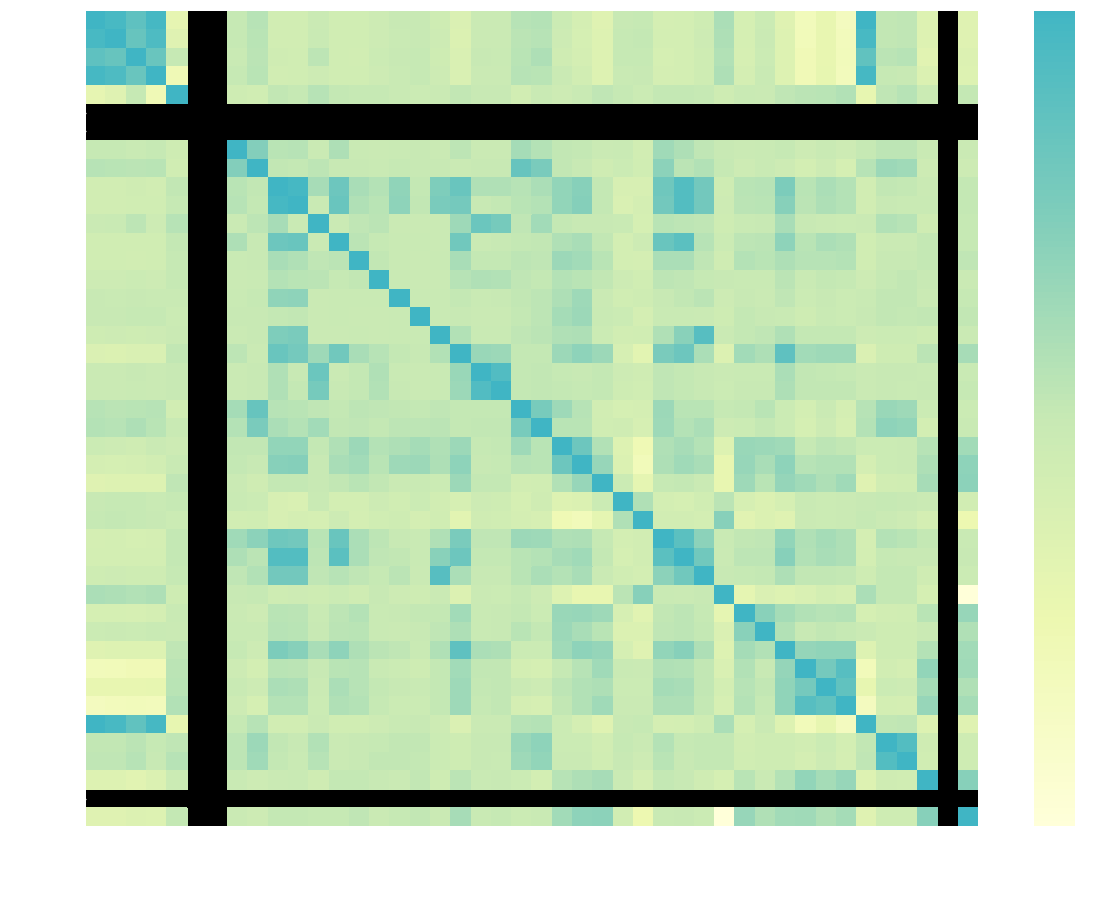

In [364]:
# correlation heat map
plt.subplots(figsize=(20,15))
sns.heatmap(demolished_buildings.corr(), center=1, cmap='YlGnBu');

__Heat Map Comments__\
The following variables will be removed because of multicolinearity:
- borocode
- cd
- schooldist
- council
- assessland
- exempttot
- unitsres
- comarea
- resarea
- officearea
- residfar
- commfar
- facilfar
- pfirm15_flag
- firm07_flag
- lotfront
- unitstotal
- bldgarea
- builtfar
- numfloors
- yearalter1
- yearalter2
- garagearea
- easements
- bldgdepth
- lotdepth
- retailarea
- otherarea
- bsmtcode
- proxcode

The following variables will be removed because there is no data:
- zonedist4
- spdist3
- overlay2

The following variables will be removed because it is not relevant:
- edesignum 

The following variables will be removed because it is redundant with another column:
- landuse, is redundant with bldgclass (see Data Dictionary.)

The following variables will be removed because it was used only to filter data, and is not needed for prediction:
- existbldg
- Issuance Year
- Issuance date

#### Removing Multicolinear Features

In [365]:
demolished_buildings = demolished_buildings.drop(axis=1, columns=['borocode', 'cd', 'schooldist', 'council', 'assessland', 'exempttot', 
                                    'unitsres', 'comarea', 'resarea', 'officearea', 'residfar', 'commfar', 'facilfar', 
                                    'pfirm15_flag', 'firm07_flag', 'spdist3', 'lotfront', 'unitstotal', 'bldgarea', 'builtfar',
                                    'numfloors', 'yearalter1', 'yearalter2', 'garagearea', 'easements', 'bldgdepth', 
                                    'lotdepth','zonedist4', 'spdist3', 'overlay2', 'existbldg', 'Issuance Year', 
                                    'retailarea', 'otherarea', 'bsmtcode', 'proxcode', 'edesignum', 'Issuance Date', 'landuse'])

#pickle and copy
with open('data/pickles/demolished_buildings.pickle', 'wb') as f:
    pickle.dump(demolished_buildings, f)

demolished_buildings = demolished_buildings.copy()

In [366]:
len(demolished_buildings.columns) #there should be 24 columns

24

__Comments__
- There are too many columns to one-hot encode without creating an extremely large dataframe, so models will be made in two batches. 
- The first batch of models will be done using only the continuous variables. 
- The second batch of models will be done using a larger set of variables.

# Feature Engineering

Taking a deeper look at each of the 24 columns to decide if features need to be binned or engineered in any way. The continuous columns 'lotarea', 'strgearea', 'factryarea', 'bldgfront', 'assesstot' can stay as-is.


__Prep for One-Hot Encoding:__

The following columns will not be used for one-hot because they contain too many unique values and will result in sparse data:\
policeprct\
healtharea

The following columns will be numerically encoded:\
zonedist3 – there are only 2 rows containing a third zoning district.\
spdist2 – there is only 1 row containing a special district 2\
ltdheight – there are only 2 rows containing a limited height district

The following columns will be binned. As these are complex with many different values, these will not be used in the first model. 

historic district\
bldgclass\
spdist1\
zonedist1\
zonedist2

The following categorical columns will be used for one hot:\
irrlotcode - already binned, one-hot will result in 2 columns\
overlay1 – already binned, one-hot will result in 10 columns\
splitzone – already binned, one-hot will result in 3 columns\
ownertype – already binned, one-hot will result in 4 columns\
ext - already binned, one-hot will result in 5 columns

In [367]:
# first batch of categorical columns for one-hot

demo_cat = demolished_buildings[['irrlotcode', 'overlay1', 'splitzone', 'ownertype', 'ext']]

cleanup = {'irrlotcode': {'N': 0, 'Y': 1},
          'overlay1': {'C2-4': 1, 'C2-3': 2, 'C1-3': 3, 'C2-2': 4, 'C1-4':5, 'C1-2':6,
                      'C1-1': 7, 'C2-1': 8, 'C1-5': 9, 'C2-5': 10},
          'splitzone': {'N': 1, 'Y': 2},
          'ownertype': {'P': 0, 'X': 1, 'C': 2, 'M': 3},
          'ext': {'N': 1, 'E': 2, 'G': 3, 'EG': 4}}

demo_cat.replace(cleanup, inplace=True)

#cleaning rows that have O instead of zero
demo_cat.loc[demo_cat['ownertype'] == 'O', 'ownertype'] = 0
demo_cat.astype('int32')

# One Hot encoding categorical columns
ohe = OneHotEncoder(drop='first', categories='auto', sparse=False, handle_unknown='error')
demo_cat = ohe.fit_transform(demo_cat)
demo_cat = pd.DataFrame(data=demo_cat)

#renaming columns 
feature_names = ohe.get_feature_names(['irrlotcode', 'overlay1', 'splitzone', 'ownertype', 'ext'])
feature_names = list(feature_names)
num_cols = list(range(0,20))
cols1 = {num_cols[i]: feature_names[i] for i in range(len(num_cols))}
demo_cat = demo_cat.rename(columns=cols1)

# pickle categorical columns
with open('data/pickles/demo_cat.pickle', 'wb') as f:
    pickle.dump(demo_cat, f)

## Binning Columns

sparse:\
zonedist3 \
spdist2\
ltdheight 

binning:\
historic district\
bldgclass\
spdist1\
zonedist1\
zonedist2

In [368]:
#binning histdist column so that all buildings in a historic district have a value of 1
demolished_buildings.loc[demolished_buildings['histdist'] != 0, 'histdist'] = 1

# coding zonedist3 so that all buildings that have a third zone are coded 1.
demolished_buildings.loc[demolished_buildings['zonedist3'] != 0, 'zonedist3'] = 1

#coding spdist2 to equal 1 for all buildings with a second special district
demolished_buildings.loc[demolished_buildings['spdist2'] != 0, 'spdist2'] = 1

#coding ltdheight to equal 1 for all buildings in a limited height district
demolished_buildings.loc[demolished_buildings['ltdheight'] != 0, 'ltdheight'] = 1

In [369]:
# changing the values to strings describing the code for easier classification prior to numerical encoding.
demolished_buildings.loc[demolished_buildings['bldgclass'].str.startswith('V'), 'bldgclass'] = 'Vacant land'
demolished_buildings.loc[demolished_buildings['bldgclass'].str.startswith('G'), 'bldgclass'] = 'Garage'
demolished_buildings.loc[demolished_buildings['bldgclass'].str.startswith('Z'), 'bldgclass'] = 'Miscellaneous'
demolished_buildings.loc[demolished_buildings['bldgclass'].str.startswith('K'), 'bldgclass'] = 'Retail'
demolished_buildings.loc[demolished_buildings['bldgclass'].str.startswith('C'), 'bldgclass'] = 'Multifamily'
demolished_buildings.loc[demolished_buildings['bldgclass'].str.startswith('M'), 'bldgclass'] = 'Religious'
demolished_buildings.loc[demolished_buildings['bldgclass'].str.startswith('E'), 'bldgclass'] = 'Warehouse'
demolished_buildings.loc[demolished_buildings['bldgclass'].str.startswith('S'), 'bldgclass'] = 'Mixed Use'
demolished_buildings.loc[demolished_buildings['bldgclass'].str.startswith('O'), 'bldgclass'] = 'Office'
demolished_buildings.loc[demolished_buildings['bldgclass'].str.startswith('F'), 'bldgclass'] = 'Industrial'
demolished_buildings.loc[demolished_buildings['bldgclass'].str.startswith('D'), 'bldgclass'] = 'Multifamily'
demolished_buildings.loc[demolished_buildings['bldgclass'].str.startswith('W'), 'bldgclass'] = 'Educational'
demolished_buildings.loc[demolished_buildings['bldgclass'].str.startswith('Q'), 'bldgclass'] = 'Recreation'
demolished_buildings.loc[demolished_buildings['bldgclass'].str.startswith('N'), 'bldgclass'] = 'Institutional'
demolished_buildings.loc[demolished_buildings['bldgclass'].str.startswith('T'), 'bldgclass'] = 'Transportation'
demolished_buildings.loc[demolished_buildings['bldgclass'].str.startswith('I'), 'bldgclass'] = 'Transportation'
demolished_buildings.loc[demolished_buildings['bldgclass'].str.startswith('Y'), 'bldgclass'] = 'Government'
demolished_buildings.loc[demolished_buildings['bldgclass'].str.startswith('H'), 'bldgclass'] = 'Hospitality'
demolished_buildings.loc[demolished_buildings['bldgclass'].str.startswith('U'), 'bldgclass'] = 'Utility'
demolished_buildings.loc[demolished_buildings['bldgclass'].str.startswith('P'), 'bldgclass'] = 'Assembly'
demolished_buildings.loc[demolished_buildings['bldgclass'].str.startswith('L'), 'bldgclass'] = 'Loft'
demolished_buildings.loc[demolished_buildings['bldgclass'].str.startswith('J'), 'bldgclass'] = 'Theatres'
demolished_buildings.loc[demolished_buildings['bldgclass'].str.startswith('R'), 'bldgclass'] = 'Multifamily'

In [370]:
#numerical encoding of bldgclass column
demolished_buildings.loc[demolished_buildings['bldgclass'] == 'Vacant land', 'bldgclass'] = 0
demolished_buildings.loc[demolished_buildings['bldgclass'] == 'Multifamily', 'bldgclass'] = 1
demolished_buildings.loc[demolished_buildings['bldgclass'] == 'Garage', 'bldgclass'] = 2
demolished_buildings.loc[demolished_buildings['bldgclass'] == 'Educational', 'bldgclass'] = 3
demolished_buildings.loc[demolished_buildings['bldgclass'] == 'Mixed Use', 'bldgclass'] = 4
demolished_buildings.loc[demolished_buildings['bldgclass'] == 'Office', 'bldgclass'] = 5
demolished_buildings.loc[demolished_buildings['bldgclass'] == 'Transportation', 'bldgclass'] = 6
demolished_buildings.loc[demolished_buildings['bldgclass'] == 'Assembly', 'bldgclass'] = 7
demolished_buildings.loc[demolished_buildings['bldgclass'] == 'Loft', 'bldgclass'] = 8
demolished_buildings.loc[demolished_buildings['bldgclass'] == 'Utility', 'bldgclass'] = 9
demolished_buildings.loc[demolished_buildings['bldgclass'] == 'Hospitality', 'bldgclass'] = 10
demolished_buildings.loc[demolished_buildings['bldgclass'] == 'Theatres', 'bldgclass'] = 11
demolished_buildings.loc[demolished_buildings['bldgclass'] == 'Government', 'bldgclass'] = 12

In [371]:
#binning of spdist1 column - putting all mixed use special districts in one bin

mx_vals = ['MX-1', 'MX-6', 'MX-8', 'MX-13', 'MX-16', 'MX-7', 'MX-2', 'MX-16/EC-5', 'MX-10', 'MX-15',
           'MX-14', 'MX-17', 'MX-11']

for index in demolished_buildings.index:
    if demolished_buildings['spdist1'][index] in mx_vals:
        demolished_buildings['spdist1'][index] = 'Special Mixed Use'

In [372]:
#binning of spdist1 column based on nyc.gov descriptions of special purpose districts.

coastal = ['CR', 'CR-1', 'CR-2', 'CR-3', 'SG', 'HRW', 'CD', 'SW']
enhanced = ['EC-1', 'EC-2', 'EC-3', 'EC-4', 'EC-5', 'EC-6']
scenic = ['NA-1', 'NA-2', 'NA-3', 'NA-4', 'SV-1', 'OP', 'HS']
development = ['SRD', 'BPC', 'EHC', 'HRP', 'HSQ', 'HY', 'I', 'MMU', 'SRI', 'TMU', 'US', 
               'U', 'WCh', 'CI', 'DB', 'LIC', 'DJ', 'SB', 'J', 'EHC/TA', 'WP', 'BSC']
business = ['MiD', '125th/TA', 'GC', 'LM', 'CP']
residential = ['CL', 'MP', 'PI', 'CO', 'BR', 'C']
commercial = ['EC-1', 'EC-2', 'EC-3', 'EC-4', 'EC-5', 'EC-6', 'LC', 'L', 'HP', 'CI', 
              '125th', 'DFR', 'CO', 'FH', 'IN']
historic = ['GI', 'LI', 'PC']
transit = ['TA']


for index in demolished_buildings.index:
    if demolished_buildings['spdist1'][index] in coastal:
        demolished_buildings['spdist1'][index] = 'Coastal Risk/Waterfront District'
        
for index in demolished_buildings.index:
    if demolished_buildings['spdist1'][index] in enhanced:
        demolished_buildings['spdist1'][index] = 'Enhanced Commercial District'
        
for index in demolished_buildings.index:
    if demolished_buildings['spdist1'][index] in scenic:
        demolished_buildings['spdist1'][index] = 'Scenic/Nature District'
        
for index in demolished_buildings.index:
    if demolished_buildings['spdist1'][index] in development:
        demolished_buildings['spdist1'][index] = 'Special Development District'
        
for index in demolished_buildings.index:
    if demolished_buildings['spdist1'][index] in transit:
        demolished_buildings['spdist1'][index] = 'Special Transit District'        
        
for index in demolished_buildings.index:
    if demolished_buildings['spdist1'][index] in historic:
        demolished_buildings['spdist1'][index] = 'Special Historic District'  
        
for index in demolished_buildings.index:
    if demolished_buildings['spdist1'][index] in business:
        demolished_buildings['spdist1'][index] = 'Special Business District'  
        
for index in demolished_buildings.index:
    if demolished_buildings['spdist1'][index] in residential:
        demolished_buildings['spdist1'][index] = 'Special Residential District'  
        
for index in demolished_buildings.index:
    if demolished_buildings['spdist1'][index] in commercial:
        demolished_buildings['spdist1'][index] = 'Enhanced Commercial District' 

In [373]:
# binning of zonedist1 column based on nyc.gov zoning districts.

for index in demolished_buildings.index:
    if demolished_buildings['zonedist1'][index] != 0:
        if demolished_buildings['zonedist1'][index].startswith('M'):
            demolished_buildings['zonedist1'][index] = 'Manufacturing'
            
for index in demolished_buildings.index:
    if demolished_buildings['zonedist1'][index] != 0:
        if demolished_buildings['zonedist1'][index].startswith('C'):
            demolished_buildings['zonedist1'][index] = 'Commercial'    
            
for index in demolished_buildings.index:
    if demolished_buildings['zonedist1'][index] != 0:
        if demolished_buildings['zonedist1'][index].startswith('R'):
            demolished_buildings['zonedist1'][index] = 'Residence'
            
for index in demolished_buildings.index:
    if demolished_buildings['zonedist1'][index] != 0:
        if demolished_buildings['zonedist1'][index].startswith('P'):
            demolished_buildings['zonedist1'][index] = 'Parkland'   
            
demolished_buildings.loc[demolished_buildings['zonedist1'] == 'BPC', 'zonedist1'] = 'Commercial'

__Refer to Zoning District Descriptions__

https://www1.nyc.gov/site/planning/zoning/districts-tools/special-purpose-districts-manhattan.page

In [374]:
# binning zonedist2 column based on nyc.gov zoning districts at the link above.

for index in demolished_buildings.index:
    if demolished_buildings['zonedist2'][index] != 0:
        if demolished_buildings['zonedist2'][index].startswith('M'):
            demolished_buildings['zonedist2'][index] = 'Manufacturing'
            
for index in demolished_buildings.index:
    if demolished_buildings['zonedist2'][index] != 0:
        if demolished_buildings['zonedist2'][index].startswith('C'):
            demolished_buildings['zonedist2'][index] = 'Commercial'    
            
for index in demolished_buildings.index:
    if demolished_buildings['zonedist2'][index] != 0:
        if demolished_buildings['zonedist2'][index].startswith('R'):
            demolished_buildings['zonedist2'][index] = 'Residence'
            
for index in demolished_buildings.index:
    if demolished_buildings['zonedist2'][index] != 0:
        if demolished_buildings['zonedist2'][index].startswith('P'):
            demolished_buildings['zonedist2'][index] = 'Parkland'  

In [375]:
#numerical encoding of zonedist2 column
demolished_buildings.loc[demolished_buildings['zonedist2'] == 'Residence', 'zonedist2'] = 1
demolished_buildings.loc[demolished_buildings['zonedist2'] == 'Commercial', 'zonedist2'] = 2
demolished_buildings.loc[demolished_buildings['zonedist2'] == 'Manufacturing', 'zonedist2'] = 3
demolished_buildings.loc[demolished_buildings['zonedist2'] == 'Parkland', 'zonedist2'] = 4

#numerical encoding of zonedist1 column
demolished_buildings.loc[demolished_buildings['zonedist1'] == 'Residence', 'zonedist1'] = 1
demolished_buildings.loc[demolished_buildings['zonedist1'] == 'Commercial', 'zonedist1'] = 2
demolished_buildings.loc[demolished_buildings['zonedist1'] == 'Manufacturing', 'zonedist1'] = 3
demolished_buildings.loc[demolished_buildings['zonedist1'] == 'Parkland', 'zonedist1'] = 4

#numerical encoding of spdist1 column
demolished_buildings.loc[demolished_buildings['spdist1'] == 'Special Development District', 'spdist1'] = 1
demolished_buildings.loc[demolished_buildings['spdist1'] == 'Special Business District', 'spdist1'] = 2
demolished_buildings.loc[demolished_buildings['spdist1'] == 'Special Mixed Use', 'spdist1'] = 3
demolished_buildings.loc[demolished_buildings['spdist1'] == 'Scenic/Nature District', 'spdist1'] = 4
demolished_buildings.loc[demolished_buildings['spdist1'] == 'Enhanced Commercial District', 'spdist1'] = 5
demolished_buildings.loc[demolished_buildings['spdist1'] == 'Special Residential District', 'spdist1'] = 6
demolished_buildings.loc[demolished_buildings['spdist1'] == 'Coastal Risk/Waterfront District', 'spdist1'] = 7
demolished_buildings.loc[demolished_buildings['spdist1'] == 'Special Transit District', 'spdist1'] = 8
demolished_buildings.loc[demolished_buildings['spdist1'] == 'Natural Area District', 'spdist1'] = 9
demolished_buildings.loc[demolished_buildings['spdist1'] == 'Special Historic District', 'spdist1'] = 10

## Second Batch of Categorical Columns

In [376]:
#cleaning rows that have O instead of zero
demolished_buildings.loc[demolished_buildings['ownertype'] == 'O', 'ownertype'] = 0

demo_cat2 = demolished_buildings[['irrlotcode', 'overlay1', 'splitzone', 'ownertype', 'ext',
                                'zonedist3', 'spdist2', 'ltdheight', 'histdist', 'bldgclass', 'spdist1', 
                                 'zonedist1', 'zonedist2']]

cleanup = {'irrlotcode': {'N': 0, 'Y': 1},
          'overlay1': {'C2-4': 1, 'C2-3': 2, 'C1-3': 3, 'C2-2': 4, 'C1-4':5, 'C1-2':6,
                      'C1-1': 7, 'C2-1': 8, 'C1-5': 9, 'C2-5': 10},
          'splitzone': {'N': 1, 'Y': 2},
          'ownertype': {'P': 0, 'X': 1, 'C': 2, 'M': 3},
          'ext': {'N': 1, 'E': 2, 'G': 3, 'EG': 4}}

demo_cat2.replace(cleanup, inplace=True)

## One Hot Encoding - Second Batch

In [377]:
object_cols = ['zonedist3', 'spdist2', 'ltdheight', 'histdist', 'bldgclass', 'spdist1', 'zonedist1', 'zonedist2']

for i in object_cols:
    demo_cat2[i] = demo_cat2[i].astype('int64')
    
demo_cat2 = demo_cat2.astype('int64')

In [378]:
cat2_cols = list(demo_cat2.columns)

ohe2 = OneHotEncoder(drop='first', categories='auto', sparse=False, handle_unknown='error')
demo_cat2 = ohe2.fit_transform(demo_cat2)
demo_cat2 = pd.DataFrame(data=demo_cat2)

#rename columns
feature_names2 = ohe2.get_feature_names(cat2_cols)
feature_names2 = list(feature_names2)
num_cols2 = list(range(0,52))
cols2 = {num_cols2[i]: feature_names2[i] for i in range(len(num_cols2))}
demo_cat2 = demo_cat2.rename(columns=cols2)

#pickle categorical columns
with open('data/pickles/demo_cat2.pickle', 'wb') as f:
    pickle.dump(demo_cat2, f)

# Exploratory Data Analysis

## Distribution of Lifespan Variable

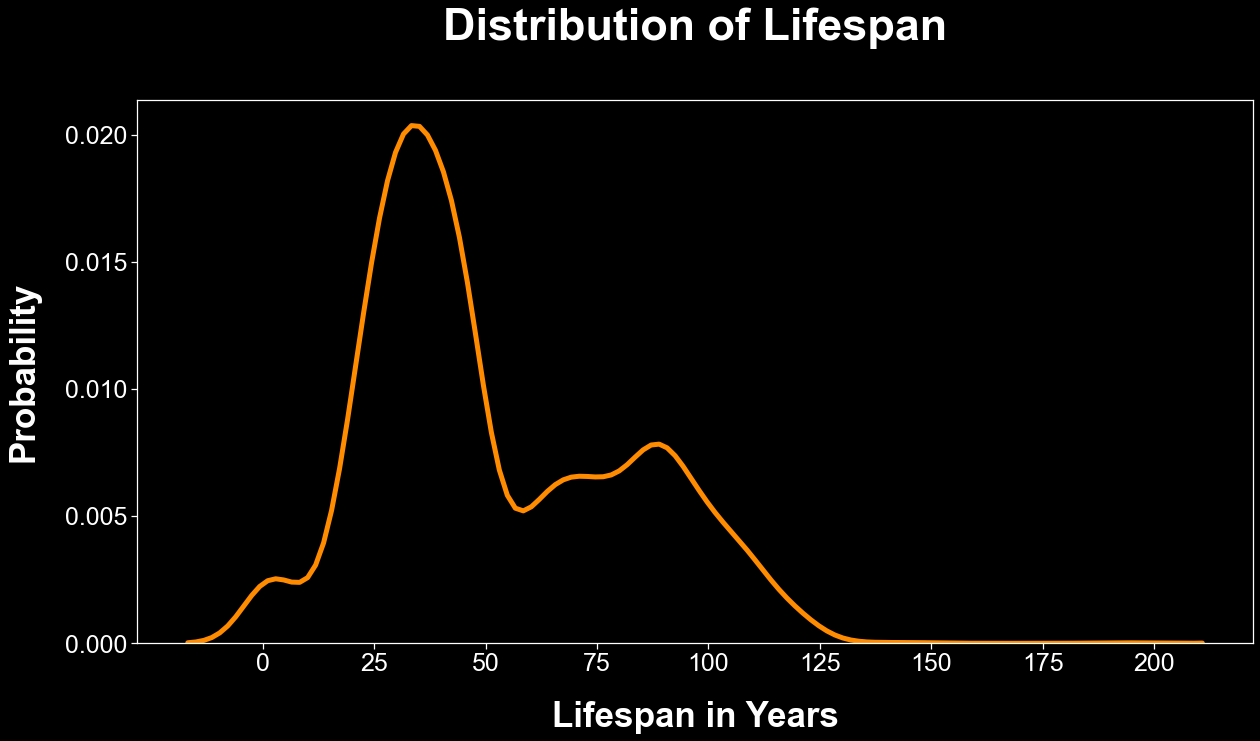

In [379]:
# graphing lifespan variable
sns.set(rc={'figure.figsize':(20,10)}, style='ticks')
plt.style.use('dark_background')

sns.distplot(demolished_buildings.lifespan, hist=False, kde=True, kde_kws={'linewidth':5}, color='darkorange')

font_lg = {'family': 'sans-serif',
        'color':  'white',
        'weight': 'bold',
        'size': 45,
        }

font_med = {'family': 'sans-serif',
        'color':  'white',
        'weight': 'bold',
        'size': 35,
        }

plt.title('Distribution of Lifespan', fontdict=font_lg, y=1.1)
plt.xlabel('Lifespan in Years', fontdict=font_med, labelpad=25)
plt.ylabel('Probability', fontdict=font_med, labelpad=25)
plt.xticks(ticks=[0, 25, 50, 75, 100, 125, 150, 175, 200], fontsize=25)
plt.yticks(ticks=[0.0, 0.005, 0.01, 0.015, 0.02], fontsize=25);

## Lifespan by Year Built

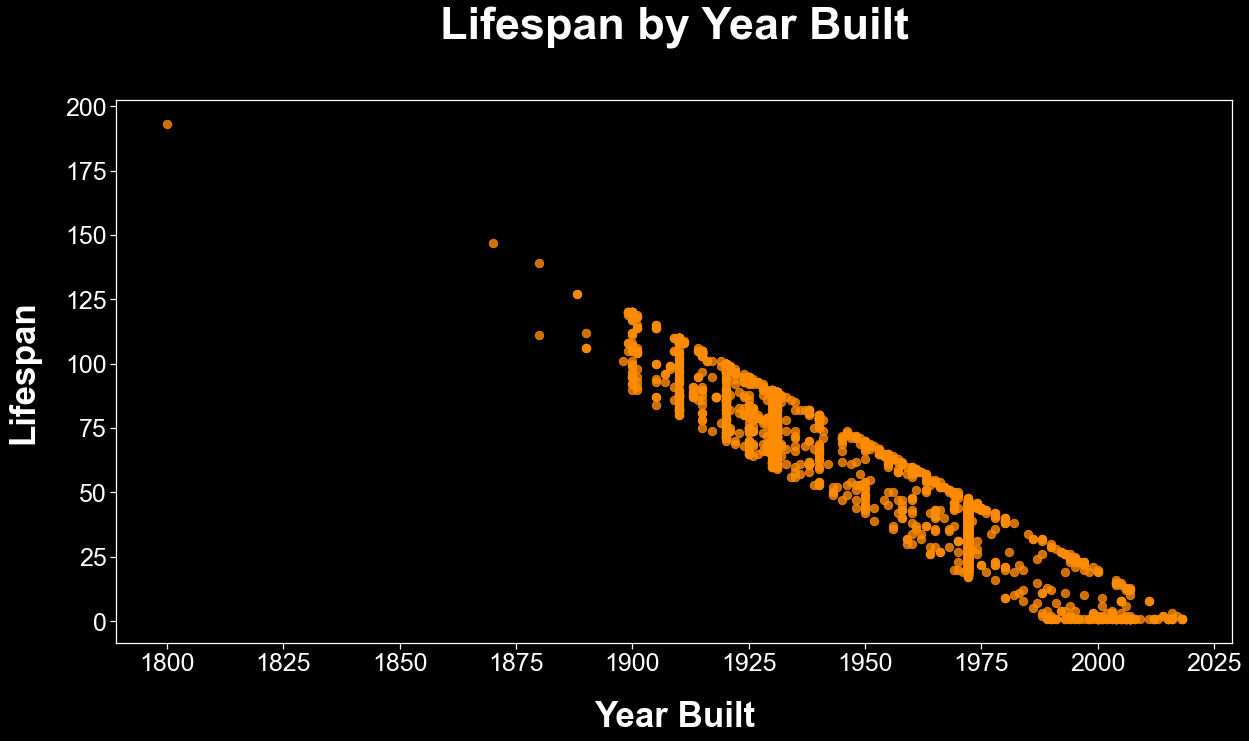

In [380]:
#graphing lifespan by year built
sns.regplot(x=demolished_buildings['yearbuilt'], 
                y=demolished_buildings['lifespan'], fit_reg=False, color='darkorange', scatter_kws={'s':70}
           ).set_title('Lifespan by Year Built');

font_lg = {'family': 'sans-serif',
        'color':  'white',
        'weight': 'bold',
        'size': 45,
        }

font_med = {'family': 'sans-serif',
        'color':  'white',
        'weight': 'bold',
        'size': 35,
        }

plt.title('Lifespan by Year Built', fontdict=font_lg, y=1.1)
plt.xlabel('Year Built', fontdict=font_med, labelpad=25)
plt.ylabel('Lifespan', fontdict=font_med, labelpad=25)
plt.xticks(ticks=[1800, 1825, 1850, 1875, 1900, 1925, 1950, 1975, 2000, 2025], fontsize=25)
plt.yticks(ticks=[0, 25, 50, 75, 100, 125, 150, 175, 200], fontsize=25);

## Lifespan by Type of Building

Text(0.5, 0, 'Number of Buildings Demolished')

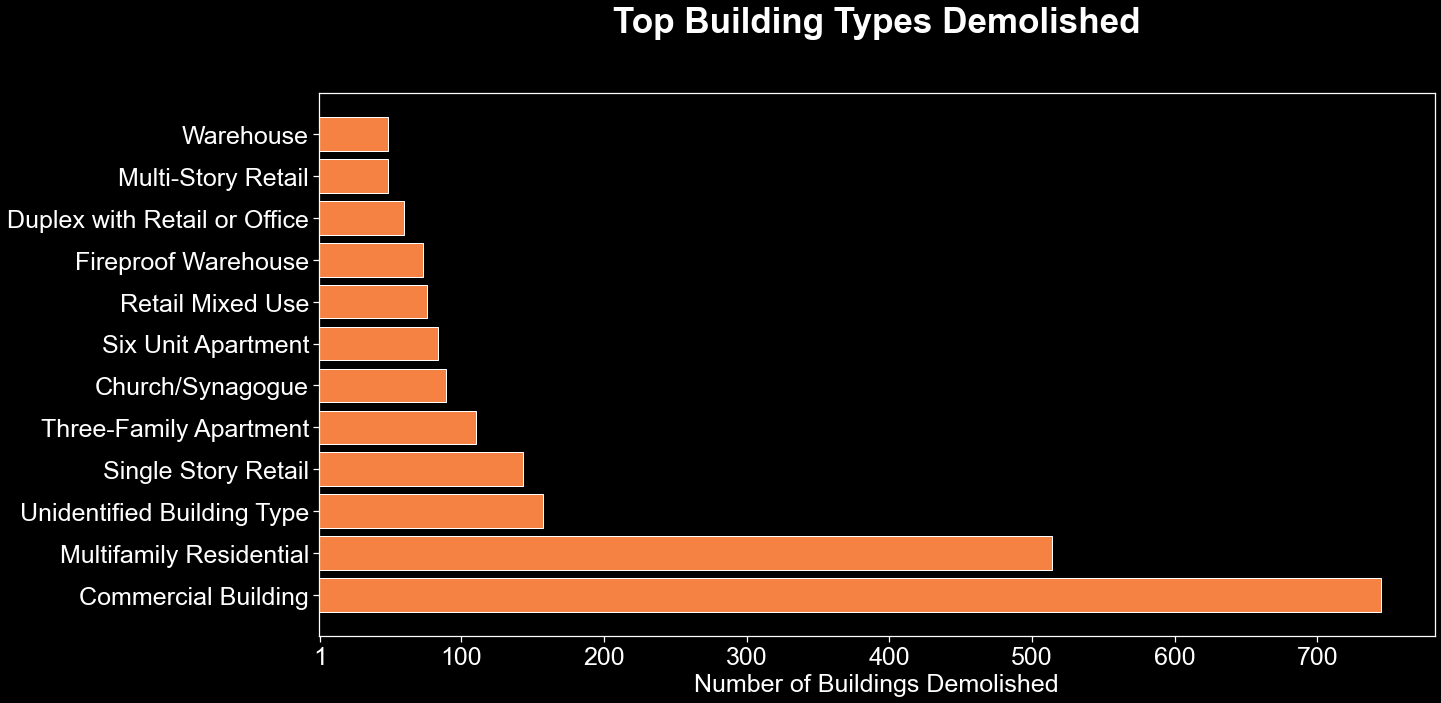

In [381]:
#bar graph by building type
Bldg_class_dict = {'Commercial Building': 745, 'Multifamily Residential': 514, 'Unidentified Building Type':157, 
                   'Single Story Retail':143, 'Three-Family Apartment': 110, 'Church/Synagogue':89, 
                   'Six Unit Apartment': 84, 'Retail Mixed Use': 76, 'Fireproof Warehouse':73, 
                   'Duplex with Retail or Office': 60, 'Multi-Story Retail': 49,
                  'Warehouse':49}

bldg_counts = list(Bldg_class_dict.values())

building_types = list(Bldg_class_dict.keys())

y_pos = np.arange(len(building_types))


font_med = {'family' : 'sans-serif',
        'weight' : 'regular',
        'size'   : 25}

font_lg = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 35}

plt.barh(y_pos, bldg_counts, height=0.8, align='center', color='#f58142')
plt.title('Top Building Types Demolished', fontdict=font_lg, y=1.1);
plt.yticks(y_pos, building_types, fontsize=25)
plt.xticks(ticks=[1, 100, 200, 300, 400, 500, 600, 700], fontsize=25)
plt.xlabel('Number of Buildings Demolished', fontdict=font_med)

# Modeling

## Import Pickle File

In [382]:
infile = open('data/pickles/demolished_buildings.pickle', 'rb')
demolished_buildings = pickle.load(infile)
infile.close()

## Splitting Continuous & Categorical Variables

In [383]:
#making a list of all columns for reference
all_cols = list(demolished_buildings.columns)
all_cols = sorted(all_cols)

# making a list of continuous columns
cont_cols = ['lotarea', 'strgearea','factryarea', 'bldgfront', 'assesstot', 'yearbuilt']

# making a dataframe of continuous columns
cont_cols_df = demolished_buildings[['lotarea', 'strgearea','factryarea', 'bldgfront', 'assesstot', 'yearbuilt']]

#making a list of categorical columns
cat_cols = []

for col in all_cols:
    if col in cont_cols:
        pass
    if col == 'lifespan':
        pass
    else:
        cat_cols.append(col)
    
print(cat_cols)
print(len(cat_cols)) #printing categorical columns

['assesstot', 'bldgclass', 'bldgfront', 'ext', 'factryarea', 'healtharea', 'histdist', 'irrlotcode', 'landmark', 'lotarea', 'lottype', 'ltdheight', 'overlay1', 'ownertype', 'policeprct', 'spdist1', 'spdist2', 'splitzone', 'strgearea', 'yearbuilt', 'zonedist1', 'zonedist2', 'zonedist3']
23


## Train Test Split

In [384]:
cont_cols_df

,lotarea,strgearea,factryarea,bldgfront,assesstot,yearbuilt
82,1840.0,0.0,0.0,0.0,478592.0,1972
106,7767.0,0.0,0.0,0.0,64380.0,1972
134,8000.0,0.0,0.0,72.0,1757700.0,1922
185,650.0,0.0,0.0,0.0,19350.0,1972
208,2500.0,0.0,0.0,0.0,67050.0,1972
...,...,...,...,...,...,...
37680,2125.0,0.0,0.0,25.0,66510.0,1920
37681,16870.0,0.0,0.0,91.5,648900.0,1930
37682,3058.0,0.0,0.0,75.5,126000.0,1930
37684,3925.0,420.0,0.0,44.0,1317600.0,2000


In [385]:
# try a model using only continous variables
X = cont_cols_df
y = demolished_buildings['lifespan']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12)

## Model 1A : Linear Regression

Using Continuous Variables only.

### From Scratch

In [386]:
def linear_reg_model(Xtrain, ytrain, Xtest, ytest):
    """
    Function takes training and test data as input and returns the following:
    - Accuracy Score
    - Coefficients
    - P-values
    - Mean squared error
    - Root mean squared error
    - R-squared
    - Cross Validation Score    
    - Residuals plot
    - Predictions Dataframe
    """
    
    #instantiate model
    model = LinearRegression(fit_intercept=True, copy_X=True).fit(Xtrain, ytrain)
    #make predictions
    y_pred = model.predict(Xtest)
    #get coefficients
    coef = model.coef_
    #make list of columns
    column_list = list(Xtrain.columns)    
    # attach names to coefficients
    coefficients = dict(zip(column_list, coef))    
    #get performance metric
    MSE = mean_squared_error(ytest, y_pred)    
    #cross validation 5 folds
    cvs = cross_val_score(estimator=model, X=Xtest, y=ytest, cv=5)        
    #make dataframe of predictions
    pred = pd.DataFrame({'Actual': ytest, 'Predicted': y_pred})
    
    #f-test to see which coefficients have p-values greater than 0.05
    f_test = feature_selection.f_regression(Xtrain, ytrain)
    pvalues = list(zip(list(Xtrain.columns), f_test[1]))
    
    large_pvalues = []
    for i in pvalues:
        if i[1] > 0.05:
            large_pvalues.append(i)
    
    print('Accuracy Score ', model.score(Xtest, ytest))    
    print('Coefficients ', coefficients)    
    print('P-Values Greater than 0.05', large_pvalues)    
    print('Mean Squared Error ', MSE)   
    print('Root Mean Squared Error ', np.sqrt(MSE))    
    print('R-Squared', r2_score(ytest, y_pred))       
    print('Cross Validation Score ', cvs)

    #plot residuals
    residuals = ytest - y_pred
    fig, ax = plt.subplots(figsize=(6,4))
    ax.scatter(residuals, y_pred)
    
    return pred

Accuracy Score  0.9016724101573149
Coefficients  {'lotarea': -3.165186189328124e-06, 'strgearea': -1.4043477822092771e-05, 'factryarea': 4.649129550462128e-05, 'bldgfront': 0.01900167271613683, 'assesstot': 1.7666912452889011e-10, 'yearbuilt': -1.039311825265042}
P-Values Greater than 0.05 [('strgearea', 0.11552716074567967), ('assesstot', 0.3608876591422222)]
Mean Squared Error  83.50043288795412
Root Mean Squared Error  9.137857127792824
R-Squared 0.9016724101573149
Cross Validation Score  [0.89272863 0.88147014 0.90693815 0.90168005 0.90782767]


,Actual,Predicted
36977,94,84.123631
35941,109,101.333591
33183,25,35.376091
13343,30,34.964462
21854,37,38.368223
...,...,...
26298,42,34.974682
37081,54,42.925295
10646,25,34.973528
35889,88,78.526495


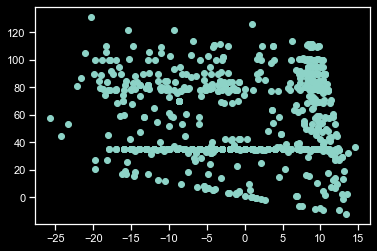

In [387]:
linear_reg_model(X_train, y_train, X_test, y_test)

__Comments__

Even though most of the data did not have a linear relationship to the target variable, the model performed well. 

The r-squared value is 0.90, which means that the model explains 90% of the variation in building lifespan.

An RMSE of 9.1 means that the predictions are off by 9 years on average in either direction.

strgarea has a p-value of 1.1155\
assesstot has a p-value of -0.360\
These are both greater than 0.05.

The residuals plot has some patterns in it, so the model can likely be improved.

__Next Steps:__

Do a double check using statsmodels to confirm the results.

### Using Statsmodels

In [388]:
Xcont_train = sm.add_constant(X_train)
Xcont_test = sm.add_constant(X_test)

model = sm.OLS(y_train, Xcont_train)
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               lifespan   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     3675.
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:59:27   Log-Likelihood:                -8551.1
No. Observations:                2373   AIC:                         1.712e+04
Df Residuals:                    2366   BIC:                         1.716e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2084.5033     14.479    143.967      0.000    2056.110    2112.896
lotarea    -3.165e-06   1.19e-06     -2.650      0.008   -5.51e-06   -8.23e-07
strgearea  -1.404e-05    5.6e-06     -2.508      0.012    -2.5e-05   -3.06e-06
factryarea  4.649e-05   4.17e-05      1.115      0.265   -3.53e-05       0.000
bldgfront      0.0190      0.004      4.854      0.000       0.011       0.027
assesstot   1.767e-10   1.91e-08      0.009      0.993   -3.73e-08    3.76e-08
yearbuilt     -1.0393      0.007   -140.685      0.000      -1.054      -1.025
==============================================================================
Omnibus:                      982.092   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.554
Skew:                          -0.329   Prob(JB):                     5.03e-36
Kurtosis:                       1.899   Cond. No.                     8.04e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.04e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [389]:
y_predict = fitted_model.predict(Xcont_test)

__Comments__

This model is a double check confirming the results of the first model.

P-value for factryarea, strgearea and assesstot are > 0.05, so these coefficients are irrelevant for predicting the target and should be dropped. However, this will result in less than 5 variables, so some of the categorical variables will need to be added.

factryarea coefficient has a value of 4.649e-05 or 464,900. This is outside of the 95% confidence interval.

assesstot coefficient has a value of 1.767e-10 or 17,670,000,000. This is outside of the 95% confidence interval.

__Next Steps__

Include Categorical Variables

## Model 2 : Linear Regression

### Using Mix of Continous & Categorical Variables

Accuracy Score  0.9097107328138474
Coefficients  {'lotarea': -1.7254352129143067e-06, 'bldgfront': 0.014024475143076023, 'yearbuilt': -1.0232335122937957, 'irrlotcode_1': 0.5278650756439531, 'overlay1_1': 2.3105150437347954, 'overlay1_2': -0.33737107044197223, 'overlay1_3': 1.0482140971629341, 'overlay1_4': -0.5272319010720671, 'overlay1_5': 2.491216084597868, 'overlay1_6': -4.523318953119099, 'overlay1_7': -3.5711709669813705, 'overlay1_8': -3.1875456453275826, 'overlay1_9': 3.7233210704783555, 'overlay1_10': 0.6139715397308068, 'splitzone_1': -9.124512727457446, 'splitzone_2': -8.075493656214785, 'ownertype_1': -3.3275492833269142, 'ownertype_2': -4.476167481879459, 'ownertype_3': -11.933208695033311, 'ext_1': 1.7152522441359503, 'ext_2': 2.7821704335884903, 'ext_3': -4.53553018404284, 'ext_4': -3.3494857004881857}
P-Values Greater than 0.05 [('irrlotcode_1', 0.055949995001861715), ('overlay1_1', 0.49523852943170665), ('overlay1_2', 0.10735711510093252), ('overlay1_3', 0.453838797275

,Actual,Predicted
36977,94,79.163347
35941,109,101.829621
33183,25,27.704093
13343,30,34.719598
21854,37,40.268588
...,...,...
26298,42,34.725192
37081,54,44.631083
10646,25,34.724559
35889,88,80.155639


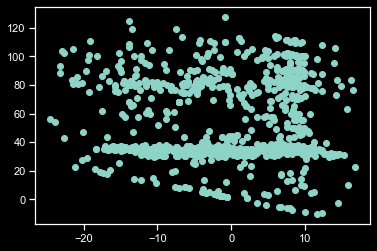

In [390]:
infile = open('data/pickles/demo_cat.pickle', 'rb')
demo_cat = pickle.load(infile)
infile.close()

#resetting index prior to merging
cont_cols_df = cont_cols_df.reset_index()

#make dataframe merging the categorical and continuous columns
df2 = cont_cols_df.merge(demo_cat, how='outer', left_index=True, right_index=True)

# now remove columns that had questionable p-values
df2 = df2.drop(axis=1, columns=['index', 'factryarea', 'strgearea', 'assesstot'])

# making a model using continous & some categorical variables
X2 = df2
y2 = demolished_buildings['lifespan']

# train test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.33, random_state=12)

# creating the model
linear_reg_model(X_train2, y_train2, X_test2, y_test2)

__Comments__

Model performance improved slightly with RMSE down to 8.7 and accuracy slightly up to 90.9%. 

Because the model improved after taking out 'factryarea', 'strgearea', 'assesstot', we can conclude that these features did not have a significant impact on the model.

Cross Validation confirms that the accuracy score of 0.95 is in the range of replicable scores.

The residuals plot shows a pattern, so there is more information that can be gleaned from the data. The pattern can be addressed by one of the following:
1. Independent variables may be missing, more variables can be included
2. The model may perform better with a polynomial term.
3. The model may perform better with an interaction term.
4. The model may perform better with columns with a p-value higher than 0.05 removed. 

Next iteration: include more categorical variables.

## Model 3A: Linear Regression 

### Using All Features Possible (Mix of Continous & Categorical Variables)

Accuracy Score  0.9193047557991171
Coefficients  {'lotarea': -9.745919417459767e-07, 'bldgfront': 0.01823119958450442, 'yearbuilt': -1.01264004627496, 'irrlotcode_1': 0.4967575017484891, 'overlay1_1': 4.360654737583763, 'overlay1_2': 2.238809182223239, 'overlay1_3': 3.376483931778153, 'overlay1_4': 2.058198007578137, 'overlay1_5': 3.989732757995451, 'overlay1_6': -2.1800249193867987, 'overlay1_7': -1.3159000621523778, 'overlay1_8': 0.3207587577585578, 'overlay1_9': 4.02272558728008, 'overlay1_10': 1.3659334880767382, 'splitzone_1': -4.932192214898141, 'splitzone_2': -4.481007497819888, 'ownertype_1': -2.026729752787885, 'ownertype_2': -5.272423995091908, 'ownertype_3': -13.121573590321956, 'ext_1': 4.0308398612586736, 'ext_2': 3.657197567382663, 'ext_3': -0.31758711577755583, 'ext_4': -0.8072142325044305, 'zonedist3_1': 0.3149595938787624, 'spdist2_1': -7.273267676869854, 'ltdheight_1': 6.217248937900877e-15, 'histdist_1': 0.022068438247968225, 'bldgclass_1': -4.646723807554703, 'bldgc

,Actual,Predicted
36977,94,82.197214
35941,109,105.505558
33183,25,32.784086
13343,30,34.850037
21854,37,38.118732
...,...,...
26298,42,34.207869
37081,54,48.148382
10646,25,29.560788
35889,88,76.290353


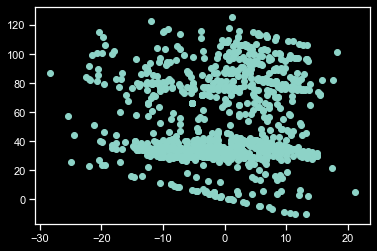

In [391]:
infile = open('data/pickles/demo_cat2.pickle', 'rb')
demo_cat2 = pickle.load(infile)
infile.close()

# make dataframe merging the categorical and continuous columns
df3 = cont_cols_df.merge(demo_cat2, how='outer', left_index=True, right_index=True)

# now remove columns that had questionable p-values
df3 = df3.drop(axis=1, columns=['index', 'factryarea', 'strgearea', 'assesstot'])

# making a model using continous & some categorical variables
X3 = df3
y3 = demolished_buildings['lifespan']

# train test split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.33, random_state=12)

# instantiating the model
linear_reg_model(X_train3, y_train3, X_test3, y_test3)

__Comments__

This model performed slightly better with 91.9% accuracy with a RMSE of 8.27. 

This means that the predictions accurate are within roughly 8 years of the actual value in either direction. This is very useful.

There are many columns with a p-value greater than 0.05. These may be able to be removed without affecting the model.

The residuals plot still shows a pattern. All possible features have been included, so the next potential steps include interactions, polynomial regression, and removing features with a high p-value.

## Model 3B: Linear Regression (including questionable features) - BEST MODEL

### In this model, keeping columns 'factryarea', 'strgearea', 'assesstot'

Accuracy Score  0.9304126452470942
Coefficients  {'index': 0.0002585706723263737, 'lotarea': 1.932708344741574e-06, 'strgearea': -1.458237369405109e-05, 'factryarea': -1.2190475626323513e-05, 'bldgfront': 0.021578390085000263, 'assesstot': -3.171961981962568e-08, 'yearbuilt': -1.0118523558047858, 'irrlotcode_1': 0.7918753686113327, 'overlay1_1': 3.9750872430890674, 'overlay1_2': 2.3179888028055866, 'overlay1_3': 3.176094924403401, 'overlay1_4': 1.6385812240479654, 'overlay1_5': 3.9114838775507668, 'overlay1_6': -2.7306926055008236, 'overlay1_7': -1.7687753258581047, 'overlay1_8': -0.22946219320879216, 'overlay1_9': 2.126636382831917, 'overlay1_10': -0.5475321971586076, 'splitzone_1': -3.70600947137119, 'splitzone_2': -4.1081185728327565, 'ownertype_1': -1.255821981430113, 'ownertype_2': -4.990749479923554, 'ownertype_3': -15.638183617550808, 'ext_1': 2.176127106212034, 'ext_2': 1.8270209041708743, 'ext_3': -1.8337048489786523, 'ext_4': -0.43204429563910496, 'zonedist3_1': -2.5120352173

,Actual,Predicted
36977,94,86.472251
35941,109,106.646706
33183,25,35.004860
13343,30,33.178370
21854,37,38.047148
...,...,...
26298,42,35.669038
37081,54,50.601596
10646,25,27.775016
35889,88,79.548000


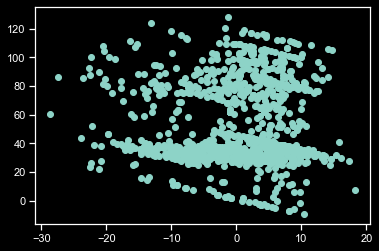

In [392]:
infile = open('data/pickles/demo_cat2.pickle', 'rb')
demo_cat2 = pickle.load(infile)
infile.close()

df4 = cont_cols_df.merge(demo_cat2, how='outer', left_index=True, right_index=True)

# making a model using continous & some categorical variables
X4 = df4
y4 = demolished_buildings['lifespan']

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.33, random_state=12)

linear_reg_model(X_train4, y_train4, X_test4, y_test4)

__Comments__

This model performed better than the prior model, indicating that features 'factryarea', 'strgearea', 'assesstot' have no meaningful impact on the model. 

This is the best model with RMSE ov 7.7 and Accuracy of 93%.


## Model 3C: Linear Regression (Limited Features)

### Using all features with a P-value below 0.05

Accuracy Score  0.913101673048248
Coefficients  {'lotarea': 3.5729052758790296e-07, 'bldgfront': 0.013570043516185138, 'yearbuilt': -1.0118732160703723, 'overlay1_7': -1.66812828129381, 'overlay1_9': 2.784255700991724, 'overlay1_10': 0.8014060478150574, 'splitzone_1': -1.729672358986328, 'ownertype_2': -4.6433323376646705, 'ext_1': 3.2142724203446327, 'ext_2': 3.3115143552338684, 'ext_3': -2.2166421407389945, 'ext_4': -1.774083977142987, 'zonedist3_1': 2.766836807600823, 'ltdheight_1': 1.360893620017123e-10, 'bldgclass_1': -3.522699659419804, 'bldgclass_2': -5.149572420650473, 'bldgclass_3': -4.048931712183283, 'bldgclass_4': 0.5356133052007644, 'bldgclass_5': -1.0003858822397027, 'bldgclass_6': -0.8843129936615605, 'bldgclass_8': 2.4937632640286074, 'spdist1_2': -0.3290874630807551, 'spdist1_4': -1.9214611406527753, 'spdist1_6': 0.5959265235138423, 'spdist1_7': -3.6644293660059515, 'spdist1_8': 6.3458223663377655, 'zonedist1_1': -0.49680449830416384, 'zonedist1_2': 5.012453996000578}


,Actual,Predicted
36977,94,81.760914
35941,109,104.547029
33183,25,32.486241
13343,30,35.721876
21854,37,38.746120
...,...,...
26298,42,35.223913
37081,54,47.997360
10646,25,31.701345
35889,88,77.675980


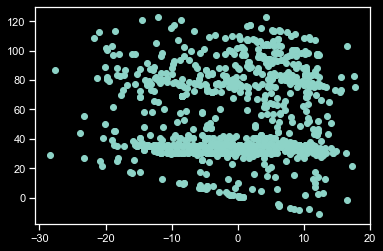

In [393]:
infile = open('data/pickles/demo_cat2.pickle', 'rb')
demo_cat2 = pickle.load(infile)
infile.close()

# make dataframe merging the categorical and continuous columns
df3C = cont_cols_df.merge(demo_cat2, how='outer', left_index=True, right_index=True)

# removing columns that had questionable p-values
df3C = df3C.drop(axis=1, columns=['index', 'factryarea', 'strgearea', 'assesstot', 'irrlotcode_1',
                                  'overlay1_1', 'overlay1_2', 'overlay1_3', 'overlay1_4', 'overlay1_5',
                                  'overlay1_6', 'overlay1_8', 'splitzone_2', 'ownertype_1', 'ownertype_3', 
                                  'spdist2_1', 'histdist_1', 'bldgclass_7', 'bldgclass_9', 'bldgclass_10',  
                                  'bldgclass_11', 'bldgclass_12', 'spdist1_1', 'spdist1_3', 'spdist1_5',
                                  'spdist1_10', 'zonedist1_3', 'zonedist1_4', 'zonedist2_1', 'zonedist2_2',
                                  'zonedist2_3'])

# making a model using continous & some categorical variables
X3C = df3C
y3C = demolished_buildings['lifespan']

# train test split
X_train3C, X_test3C, y_train3C, y_test3C = train_test_split(X3C, y3C, test_size=0.33, random_state=12)

# instantiating the model
linear_reg_model(X_train3C, y_train3C, X_test3C, y_test3C)

__Comments__

This model performed well with an accuracy of .92 and RMSE of 7.9.

# Conclusion

Since the residuals plot has not improved, interaction terms and polynomial regression were attempted - see file 03_Modeling. However, neither approach yielded any improvement in model performance or residual plot. 